## Assignment 01. Simple text processing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython import display
from sklearn.preprocessing import MinMaxScaler

### Toxic or not
Your main goal in this assignment is to classify, whether the comments are toxic or not. And practice with both classical approaches and PyTorch in the process.

*Credits: This homework is inspired by YSDA NLP_course.*

In [43]:
# In colab run this cell
! wget https://raw.githubusercontent.com/girafe-ai/natural-language-processing/22f_msai/homeworks/assignment01_word_vectors/utils.py -nc
! wget https://raw.githubusercontent.com/girafe-ai/natural-language-processing/22f_msai/homeworks/assignment01_word_vectors/features.py -nc

File ‘utils.py’ already there; not retrieving.

File ‘features.py’ already there; not retrieving.



In [2]:
try:
    data = pd.read_csv('../../datasets/comments_small_dataset/comments.tsv', sep='\t')
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/girafe-ai/ml-course/master/datasets/comments_small_dataset/comments.tsv -nc
    data = pd.read_csv("comments.tsv", sep='\t')

--2022-11-05 04:39:19--  https://raw.githubusercontent.com/girafe-ai/ml-course/master/datasets/comments_small_dataset/comments.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353358 (345K) [text/plain]
Saving to: ‘comments.tsv’

comments.tsv        100%[===================>] 345.08K  --.-KB/s    in 0.03s   

2022-11-05 04:39:19 (10.2 MB/s) - ‘comments.tsv’ saved [353358/353358]



In [3]:
texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [4]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)
# print(texts_train)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [5]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


In [7]:
# task: preprocess each comment in train and test

texts_train = [preprocess(string)  for string in texts_train] 
texts_test = [preprocess(string)  for string in texts_test]

In [8]:
# Small check that everything is done properly
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Step 1: bag of words

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [ ]:
# texts_train

In [9]:
from features import BoW

# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = min(10000, len(set(' '.join(texts_train).split())))

#<YOUR CODE>
bow = BoW(k)
bow.fit(texts_train)

print('example features:', bow.get_vocabulary()[::100])

example features: ['i', 'shown', 'attempting', 'pack', 'projects', 'sh', 'hoops', 'athanasiou', 'rey', 'what', '14:56', 'linking', 'due', 'achof', 'consumers', 'numbered', '@', 'victor', 'wine', 'michael', 'skepticism', 'thoughtlessness', 'authenticity', 'nz', 'held', 'administrator', 'overpopulated', 'room', 'player', 'adopted', '90', 'ref', 'heritage', 'frequent', 'dare', 'ddduu', 'goodness', '❤', 'perceived', 'puzzled', 'confused', 'hundreds', 'persons', 'acting', 'defense', 'khartoum', 'trio', 'grüßen', 'cocksucking', 'toot', 'dress', 'rather', 'guidance', 'girl', 'playing', 'waddle', 'inconsistent', 'wikt']


In [10]:
X_train_bow = bow.transform(texts_train)
X_test_bow = bow.transform(texts_test)

In [11]:
X_train_bow.shape

(500, 5707)

In [12]:
X_test_bow.shape

(500, 5707)

In [13]:
# Small check that everything is done properly
bow_vocabulary = bow.get_vocabulary()
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Now let's do the trick with `sklearn` logistic regression implementation:

In [14]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

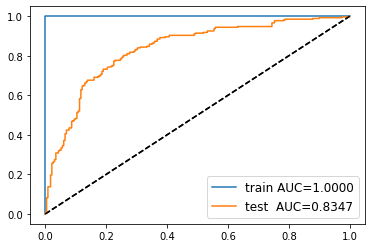

In [15]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_sklearn_roc_auc_score(X_train, y_train, X_test, y_test, model_for_auc):
    
    for name, X, y, model in [
    ('train', X_train, y_train, model_for_auc),
    ('test ', X_test, y_test, model_for_auc)
    ]:
        proba = model.predict_proba(X)[:, 1]
        auc = roc_auc_score(y, proba)
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

        plt.plot([0, 1], [0, 1], '--', color='black',)
        plt.legend(fontsize='large')
        plt.grid()

plot_sklearn_roc_auc_score(X_train_bow, y_train, X_test_bow, y_test, bow_model)

Seems alright. Now let's create the simple logistic regression using PyTorch. Just like in the classwork.

In [16]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from sklearn.metrics import accuracy_score

In [22]:
from utils import plot_train_process

In [23]:
device = torch.device('cuda:0') if torch.cuda.is_available else torch.device('cpu')
device = torch.device('cpu')

In [24]:
from torch.nn.modules.activation import ReLU

features = min(k, k_max)
classes = 2
model = nn.Sequential(  
  nn.Linear(features, classes)
)

model.to(device)

Sequential(
  (0): Linear(in_features=5707, out_features=2, bias=True)
)

Remember what we discussed about loss functions! `nn.CrossEntropyLoss` combines both log-softmax and `NLLLoss`.

__Be careful with it! Criterion `nn.CrossEntropyLoss` with still work with log-softmax output, but it won't allow you to converge to the optimum.__ Next comes small demonstration:

In [25]:
# loss_function = nn.NLLLoss()
loss_function = nn.CrossEntropyLoss()

In [26]:
### YOUR CODE HERE
opt = torch.optim.Adam(model.parameters(), lr=1e-3) 

In [27]:
type(X_train_bow)

numpy.ndarray

In [ ]:
X_train_bow_torch = torch.from_numpy(X_train_bow).to(device)
X_test_bow_torch = torch.from_numpy(X_test_bow).to(device)

y_train_torch = torch.from_numpy(y_train).to(device)
y_test_torch = torch.from_numpy(y_test).to(device)

In [ ]:
X_train_bow_torch

tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 4.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [35.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  ...,  0.,  0.,  0.]], device='cuda:0')

In [ ]:
X_test_bow_torch

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [4., 1., 0.,  ..., 0., 0., 0.]], device='cuda:0')

Let's test that everything is fine

In [ ]:
loss_func = loss_function(model(X_train_bow_torch[:3]), y_train_torch[:3])

In [ ]:
assert type(loss_func.item()) == float

Here comes small function to train the model. In future we will take in into separate file, but for this homework it's ok to implement it here. 

In [32]:
def train_model(
    model,
    opt,
    lr_scheduler,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    loss_func, 
    n_iterations=500,
    batch_size=32,
    warm_start=False,
    show_plots=True,
    eval_every=10
):
    if not warm_start:
        for name, module in model.named_children():
            print('resetting ', name)
            try:
                module.reset_parameters()
            except AttributeError as e:
                print('Cannot reset {} module parameters: {}'.format(name, e))

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):

        # sample 256 random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # predict log-probabilities or logits
        ### YOUR CODE
        y_predicted = model(x_batch) 
        y_predicted = y_predicted.to(device)

        # compute loss, just like before
        ### YOUR CODE        
        loss = loss_function(y_predicted, y_batch) 

        # compute gradients
        ### YOUR CODE
        loss.backward()

        # Adam step
        ### YOUR CODE
        opt.step()

        # clear gradients
        ### YOUR CODE
        opt.zero_grad()       


        local_train_loss_history.append(loss.data.cpu().numpy())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.cpu().detach().numpy(),
                y_predicted.cpu().detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)
            # lr_scheduler.step(train_loss_history[-1])
            lr_scheduler.step()

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

Let's run it on the data. Note, that here we use the `test` part of the data for validation. It's not so good idea in general, but in this task our main goal is practice.

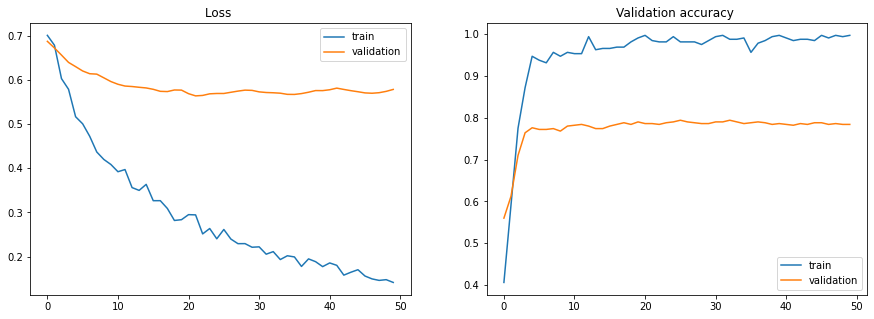

Sequential(
  (0): Linear(in_features=5707, out_features=2, bias=True)
)

In [ ]:
lr_scheduler=torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)
train_model(model, opt, lr_scheduler, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch, loss_func=loss_func)

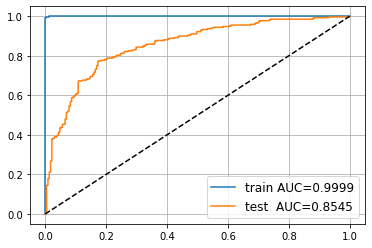

In [ ]:
for name, X, y, model in [
    ('train', X_train_bow_torch, y_train, model),
    ('test ', X_test_bow_torch, y_test, model)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.

  0%|          | 0/57 [00:00<?, ?it/s]

resetting  0


  2%|▏         | 1/57 [00:04<04:13,  4.52s/it]

resetting  0


  4%|▎         | 2/57 [00:09<04:10,  4.55s/it]

resetting  0


  5%|▌         | 3/57 [00:13<04:09,  4.63s/it]

resetting  0


  7%|▋         | 4/57 [00:19<04:17,  4.87s/it]

resetting  0


  9%|▉         | 5/57 [00:25<04:37,  5.34s/it]

resetting  0


 11%|█         | 6/57 [00:30<04:27,  5.25s/it]

resetting  0


 12%|█▏        | 7/57 [00:35<04:20,  5.20s/it]

resetting  0


 14%|█▍        | 8/57 [00:40<04:15,  5.21s/it]

resetting  0


 16%|█▌        | 9/57 [00:46<04:12,  5.26s/it]

resetting  0


 18%|█▊        | 10/57 [00:51<04:16,  5.46s/it]

resetting  0


 19%|█▉        | 11/57 [00:57<04:11,  5.47s/it]

resetting  0


 21%|██        | 12/57 [01:03<04:08,  5.52s/it]

resetting  0


 23%|██▎       | 13/57 [01:08<04:05,  5.58s/it]

resetting  0


 25%|██▍       | 14/57 [01:14<04:04,  5.69s/it]

resetting  0


 26%|██▋       | 15/57 [01:20<04:03,  5.80s/it]

resetting  0


 28%|██▊       | 16/57 [01:26<04:01,  5.89s/it]

resetting  0


 30%|██▉       | 17/57 [01:33<04:00,  6.01s/it]

resetting  0


 32%|███▏      | 18/57 [01:39<03:59,  6.15s/it]

resetting  0


 33%|███▎      | 19/57 [01:46<03:56,  6.22s/it]

resetting  0


 35%|███▌      | 20/57 [01:52<03:53,  6.32s/it]

resetting  0


 37%|███▋      | 21/57 [01:59<03:51,  6.43s/it]

resetting  0


 39%|███▊      | 22/57 [02:06<03:48,  6.54s/it]

resetting  0


 40%|████      | 23/57 [02:13<03:50,  6.78s/it]

resetting  0


 42%|████▏     | 24/57 [02:20<03:45,  6.83s/it]

resetting  0


 44%|████▍     | 25/57 [02:27<03:40,  6.90s/it]

resetting  0


 46%|████▌     | 26/57 [02:34<03:35,  6.96s/it]

resetting  0


 47%|████▋     | 27/57 [02:41<03:32,  7.07s/it]

resetting  0


 49%|████▉     | 28/57 [02:49<03:27,  7.15s/it]

resetting  0


 51%|█████     | 29/57 [02:58<03:36,  7.73s/it]

resetting  0


 53%|█████▎    | 30/57 [03:05<03:28,  7.72s/it]

resetting  0


 54%|█████▍    | 31/57 [03:13<03:21,  7.73s/it]

resetting  0


 56%|█████▌    | 32/57 [03:22<03:18,  7.93s/it]

resetting  0


 58%|█████▊    | 33/57 [03:30<03:10,  7.94s/it]

resetting  0


 60%|█████▉    | 34/57 [03:38<03:03,  7.98s/it]

resetting  0


 61%|██████▏   | 35/57 [03:46<02:56,  8.04s/it]

resetting  0


 63%|██████▎   | 36/57 [03:56<03:03,  8.72s/it]

resetting  0


 65%|██████▍   | 37/57 [04:05<02:52,  8.64s/it]

resetting  0


 67%|██████▋   | 38/57 [04:13<02:43,  8.62s/it]

resetting  0


 68%|██████▊   | 39/57 [04:22<02:35,  8.63s/it]

resetting  0


 70%|███████   | 40/57 [04:30<02:26,  8.63s/it]

resetting  0


 72%|███████▏  | 41/57 [04:39<02:18,  8.68s/it]

resetting  0


 74%|███████▎  | 42/57 [04:48<02:11,  8.76s/it]

resetting  0


 75%|███████▌  | 43/57 [04:57<02:04,  8.88s/it]

resetting  0


 77%|███████▋  | 44/57 [05:06<01:56,  8.95s/it]

resetting  0


 79%|███████▉  | 45/57 [05:17<01:54,  9.52s/it]

resetting  0


 81%|████████  | 46/57 [05:27<01:45,  9.56s/it]

resetting  0


 82%|████████▏ | 47/57 [05:36<01:35,  9.54s/it]

resetting  0


 84%|████████▍ | 48/57 [05:46<01:26,  9.58s/it]

resetting  0


 86%|████████▌ | 49/57 [05:56<01:17,  9.64s/it]

resetting  0


 88%|████████▊ | 50/57 [06:06<01:07,  9.71s/it]

resetting  0


 89%|████████▉ | 51/57 [06:16<00:58,  9.78s/it]

resetting  0


 91%|█████████ | 52/57 [06:26<00:49,  9.87s/it]

resetting  0


 93%|█████████▎| 53/57 [06:36<00:39,  9.97s/it]

resetting  0


 95%|█████████▍| 54/57 [06:46<00:30, 10.07s/it]

resetting  0


 96%|█████████▋| 55/57 [06:57<00:20, 10.20s/it]

resetting  0


 98%|█████████▊| 56/57 [07:07<00:10, 10.32s/it]

resetting  0


100%|██████████| 57/57 [07:18<00:00,  7.69s/it]


Text(0.5, 0, 'k')

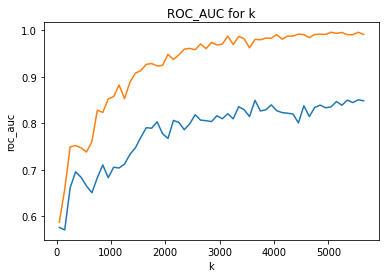

In [ ]:
# Your beautiful code here
from tqdm import tqdm, trange

i_res_test = []
i_res_train = []
auc_res_test = []
auc_res_train = []

for i in trange(50, k_max, 100):
    bow = BoW(i)
    bow.fit(texts_train)

    X_train_bow = bow.transform(texts_train)
    X_test_bow = bow.transform(texts_test)

    features = X_train_bow.shape[1]
    classes = 2
    
    model = nn.Sequential(
        nn.Linear(features, classes)
        )

    model.to(device)

    loss_function = nn.CrossEntropyLoss()

    opt = torch.optim.Adam(model.parameters(), lr=1e-3) 

    X_train_bow_torch = torch.from_numpy(X_train_bow).to(device)
    X_test_bow_torch = torch.from_numpy(X_test_bow).to(device)

    y_train_torch = torch.from_numpy(y_train).to(device)
    y_test_torch = torch.from_numpy(y_test).to(device)

    lr_scheduler=torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)
    train_model(model, opt, lr_scheduler, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch, loss_func=loss_func, show_plots=False)

    proba = model(X_test_bow_torch).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y_test, proba)

    i_res_test.append(i)
    auc_res_test.append(auc)

    proba = model(X_train_bow_torch).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y_train, proba)

    i_res_train.append(i)
    auc_res_train.append(auc)
        
plt.plot(i_res_test, auc_res_test, label = 'Test')
plt.plot(i_res_train, auc_res_train, label = 'Train')
plt.title('ROC_AUC for k')
plt.ylabel('roc_auc')
plt.xlabel('k')

**Conclusion:**


---


***As the k (number of tokens) used increases, the result improves.***


---



### Step 2: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ You can still use 'em for debugging though.

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

In [17]:
from features import TfIdf

# Your beautiful code here

tf_idf = TfIdf(k, normalize = True)
tf_idf.fit(texts_train)

In [18]:
X_train_tf_idf = tf_idf.transform(texts_train)
X_test_tf_idf = tf_idf.transform(texts_test)

Same stuff about moel and optimizers here (or just omit it, if you are using the same model as before).

In [19]:
tf_model = LogisticRegression().fit(X_train_tf_idf, y_train)

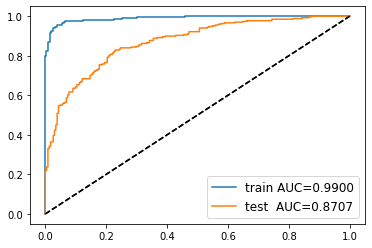

In [20]:
plot_sklearn_roc_auc_score(X_train_tf_idf, y_train, X_test_tf_idf, y_test, tf_model)

In [28]:
### YOUR CODE HERE
X_train_tfidf_torch = torch.from_numpy(X_train_tf_idf).to(device) 
X_test_tfidf_torch = torch.from_numpy(X_test_tf_idf).to(device)

y_train_torch = torch.from_numpy(y_train).to(device)
y_test_torch = torch.from_numpy(y_test).to(device)

In [29]:
X_train_tfidf_torch.shape

torch.Size([500, 5707])

In [30]:
features = min(k, k_max)
classes = 2
model_tfidf = nn.Sequential(  
  nn.Linear(features, classes)
  # nn.ReLU(),
  # nn.Linear(1024, classes)  
)

model_tfidf.to(device)

Sequential(
  (0): Linear(in_features=5707, out_features=2, bias=True)
)

Fit your model to the data. No not hesitate to vary number of iterations, learning rate and so on.

_Note: due to very small dataset, increasing the complexity of the network might not be the best idea._

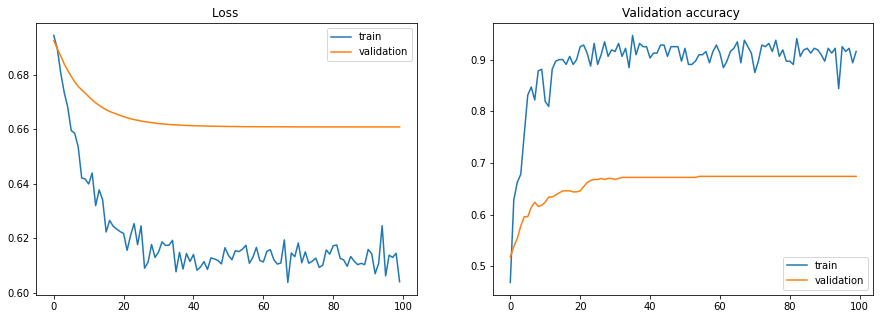

Sequential(
  (0): Linear(in_features=5707, out_features=2, bias=True)
)

In [33]:
loss_func1 = nn.CrossEntropyLoss()
opt1 = torch.optim.Adam(model_tfidf.parameters(), lr=1e-3) 

lr_scheduler=torch.optim.lr_scheduler.ExponentialLR(opt1, gamma=0.9)
train_model(model_tfidf, opt1, lr_scheduler, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch, loss_func=loss_func1, n_iterations=1000)

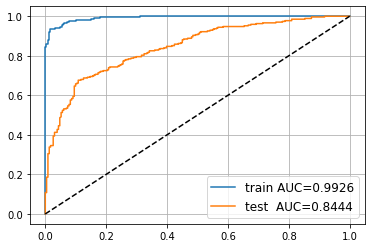

In [34]:
for name, X, y, model in [
    ('train', X_train_tfidf_torch, y_train, model_tfidf),
    ('test ', X_test_tfidf_torch, y_test, model_tfidf)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

### Step 3: Comparing it with Naive Bayes

Naive Bayes classifier is a good choice for such small problems. Try to tune it for both BOW and TF-iDF features. Compare the results with Logistic Regression.

In [39]:
# Your beautiful code here
from sklearn.naive_bayes import GaussianNB, MultinomialNB, CategoricalNB, ComplementNB

gnb_bow = MultinomialNB().fit(X_train_bow, y_train)

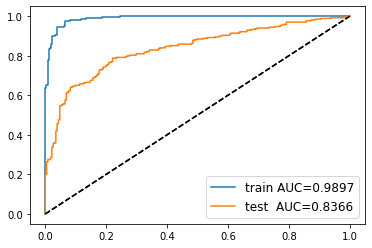

In [40]:
plot_sklearn_roc_auc_score(X_train_bow, y_train, X_test_bow, y_test, gnb_bow)

In [41]:
gnb_tfidf = MultinomialNB().fit(X_train_tf_idf, y_train)

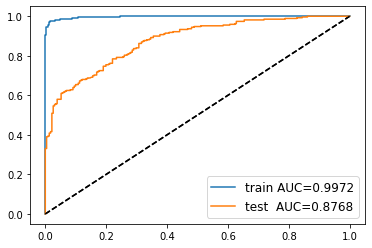

In [42]:
plot_sklearn_roc_auc_score(X_train_tf_idf, y_train, X_test_tf_idf, y_test, gnb_tfidf)

Shape some thoughts on the results you aquired. Which model has show the best performance? Did changing the learning rate/lr scheduler help?

**MY CONLUSION:**



---

**As the graphs show, the result of Tf-Idf better then BoW.**

LogisticRegression - 0.8545 (BoW) | **0.8707 (TF-IDF)**

Naive Bayes(test) - 0.8366 (BoW) | **0.8768 (TF-IDF)**

---



### Step 4: Using the external knowledge.

Use the `gensim` word2vec pretrained model to translate words into vectors. Use several models with this new encoding technique. Compare the results, share your thoughts.

**MY CONLUSION:**



---


We have too small a dataset - it is very difficult to achieve a good result on it, even when using good embeddings.


Models using such big and good embeddings should be able to train a large number of parameters. But it is very difficult with a small dataset.

AND! It may not be very well to average embeddings.
But at the moment, there are no other thoughts yet.



---



In [ ]:
# Your beautiful code here

In [44]:
from gensim import downloader as api
print(list(api.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
model = api.load('word2vec-google-news-300')

In [47]:
def get_phrase_embedding(phrase, model):    
    # Tokenize phrase, take embedding vectors for each word and return their mean.
    words = tokenizer.tokenize(phrase.lower())
    word_vectors = np.array([model.get_vector(word) for word in phrase if word in model])
    if word_vectors.size == 0:
        return np.zeros(model.vector_size)

    return word_vectors.mean(axis=0)

In [ ]:
texts_train = [get_phrase_embedding(phrase, model)  for phrase in texts_train] 
texts_test = [get_phrase_embedding(phrase, model)  for phrase in texts_test]

X_train_torch = torch.from_numpy(np.array(texts_train)).to(device)
X_test_torch = torch.from_numpy(np.array(texts_test)).to(device)

y_train_torch = torch.from_numpy(np.array(y_train)).to(device)
y_test_torch = torch.from_numpy(np.array(y_test)).to(device)

In [ ]:
features = X_train_torch.shape[1]
classes = 2
model_embedings = nn.Sequential(  
  nn.Linear(features, 2)
)

model_embedings.to(device)

Sequential(
  (0): Linear(in_features=300, out_features=2, bias=True)
)

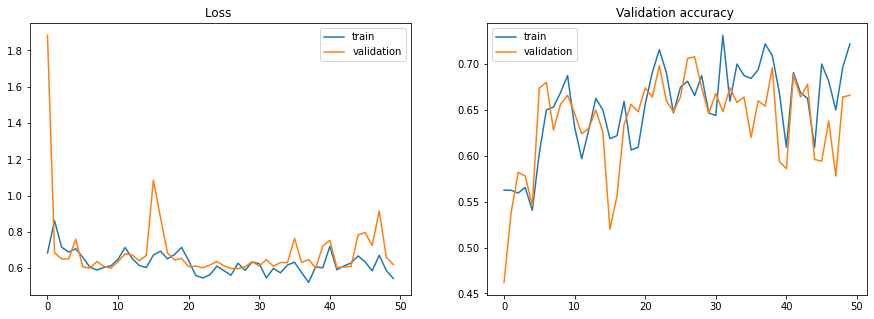

Sequential(
  (0): Linear(in_features=300, out_features=2, bias=True)
)

In [ ]:
loss_function = nn.CrossEntropyLoss()

opt = torch.optim.Adam(model_embedings.parameters(), lr=1e-1) 

lr_scheduler=torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.7)
train_model(model_embedings, opt, lr_scheduler, X_train_torch, y_train_torch, X_test_torch, y_test_torch, , loss_func = loss_function)

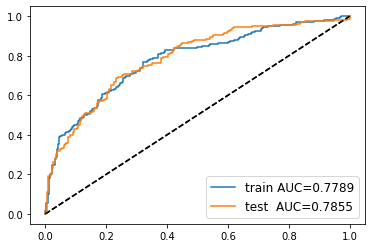

In [53]:
def plot_torch_auc(X_train, y_train, X_test, y_test, current_model):
    for name, X, y, model in [
        ('train', X_train, y_train, current_model),
        ('test ', X_test, y_test, current_model)
        ]:
        
        proba = model(X).detach().cpu().numpy()[:, 1]
        auc = roc_auc_score(y.cpu(), proba)
        plt.plot(*roc_curve(y.cpu(), proba)[:2], label='%s AUC=%.4f' % (name, auc))
        
        plt.plot([0, 1], [0, 1], '--', color='black',)
        plt.legend(fontsize='large')
        plt.grid()

plot_torch_auc(X_train_torch, y_train_torch, X_test_torch, y_test_torch, model_embedings)        

In [ ]:
model = api.load('glove-twitter-200')

[==================================================] 100.0% 758.5/758.5MB downloaded


In [ ]:
def get_phrase_embedding(phrase, model):    
    # Tokenize phrase, take embedding vectors for each word and return their mean.
    words = tokenizer.tokenize(phrase.lower())
    word_vectors = np.array([model.get_vector(word) for word in phrase if word in model])
    if word_vectors.size == 0:
        return np.zeros(model.vector_size)

    return word_vectors.mean(axis=0)

In [ ]:
texts_train = [get_phrase_embedding(phrase, model)  for phrase in texts_train] 
texts_test = [get_phrase_embedding(phrase, model)  for phrase in texts_test]

X_train_torch = torch.from_numpy(np.array(texts_train)).to(device)
X_test_torch = torch.from_numpy(np.array(texts_test)).to(device)

y_train_torch = torch.from_numpy(np.array(y_train)).to(device)
y_test_torch = torch.from_numpy(np.array(y_test)).to(device)

In [ ]:
from torch.nn.modules.activation import ReLU

features = X_train_torch.shape[1]
classes = 2
model_embedings = nn.Sequential(  
  nn.Linear(features, 2)
)

model_embedings.to(device)

Sequential(
  (0): Linear(in_features=200, out_features=2, bias=True)
)

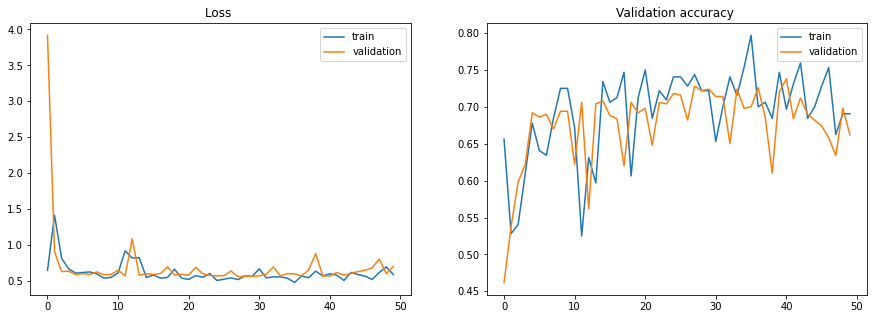

Sequential(
  (0): Linear(in_features=200, out_features=2, bias=True)
)

In [ ]:
loss_function = nn.CrossEntropyLoss()

opt = torch.optim.Adam(model_embedings.parameters(), lr=1e-1) 

lr_scheduler=torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)
train_model(model_embedings, opt, lr_scheduler, X_train_torch, y_train_torch, X_test_torch, y_test_torch, loss_func = loss_function)

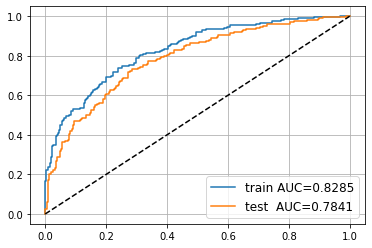

In [ ]:
plot_torch_auc(X_train_torch, y_train_torch, X_test_torch, y_test_torch, model_embedings)

In [45]:
model = api.load('glove-twitter-50')

[==================================================] 100.0% 199.5/199.5MB downloaded


In [48]:
texts_train = [get_phrase_embedding(phrase, model)  for phrase in texts_train] 
texts_test = [get_phrase_embedding(phrase, model)  for phrase in texts_test]

X_train_torch = torch.from_numpy(np.array(texts_train)).to(device)
X_test_torch = torch.from_numpy(np.array(texts_test)).to(device)

y_train_torch = torch.from_numpy(np.array(y_train)).to(device)
y_test_torch = torch.from_numpy(np.array(y_test)).to(device)

In [49]:
features = X_train_torch.shape[1]
classes = 2
model_embedings = nn.Sequential(  
  nn.Linear(features, 2)
)

model_embedings.to(device)

Sequential(
  (0): Linear(in_features=50, out_features=2, bias=True)
)

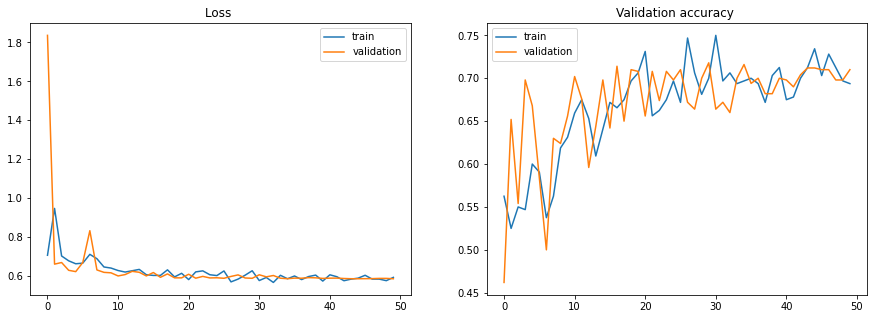

Sequential(
  (0): Linear(in_features=50, out_features=2, bias=True)
)

In [51]:
loss_function = nn.CrossEntropyLoss()

opt = torch.optim.Adam(model_embedings.parameters(), lr=1e-1) 

lr_scheduler=torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)
train_model(model_embedings, opt, lr_scheduler, X_train_torch, y_train_torch, X_test_torch, y_test_torch, loss_func = loss_function)

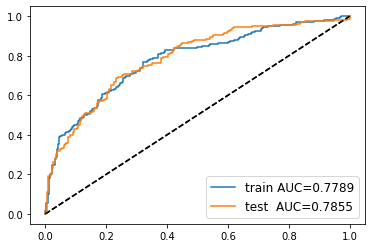

In [54]:
plot_torch_auc(X_train_torch, y_train_torch, X_test_torch, y_test_torch, model_embedings)